# Step 1: get data from Twi-XL database

In [ ]:
# install the newest development version of twi-xl-python.
!pip install git+https://gitlab.com/twi-xl-surf-nl/twi-xl-python.git@73039c837dcce371c8ba4d25f1f7533f9763c954 --force-reinstall

In [ ]:
!/opt/homebrew/Cellar/jupyterlab/4.0.12/libexec/bin/python -m pip install --upgrade pip

In [3]:
from twixl.collections import twitter
from datetime import datetime
import twixl
import os
from sklearn.model_selection import train_test_split
import datetime
import pandas as pd

/Library/Python/3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
# Set development twi-xl api endpoint.
os.environ["TWIXL_API_ENDPOINT"] = "https://ftmgjhmifb.execute-api.eu-central-1.amazonaws.com/politics"
os.environ["TWIXL_API_KEY"] = "Ad39ewyYoakVZsz2qd6a0dBoKFnmZCX7EkV1334IvSs0"

In [ ]:
#Create list of author id's
with open("./MPs_twitter_usernames.txt", "r") as f:
    authors = f.read().splitlines()

In [ ]:
authors[:4]

In [ ]:
#Create a query to search tweets from listed authors.

# Only search politics dataset (i.e. dnpp Groningen archive and profile scraper)
query_authors_only_politics = (
    twitter.Query(
        dataset=twitter.dataset.POLITICS)
        .from_usernames(authors)
)
# Only search twinl dataset
query_authors_only_twinl = (
    twitter.Query(
        dataset=twitter.dataset.TWINL)
        .from_usernames(authors)
)
# Default is to search ALL archives (i.e. twinl and politics datasets)
query_authors = (
    twitter.Query()
        .from_usernames('sybrandbuma')
)

In [ ]:
query_authors.print()

In [ ]:
# Define an empty DataFrame to store the results
final_df = pd.DataFrame()

# Loop over the list of author names
for author in authors:
    # Define the query for each author
    query_authors = (
        twitter.Query()
            .from_usernames([author])
    )
    
    # Search Twitter archive for each author
    search_results = twitter.search(
        query=query_authors,
        start_time=datetime.datetime(2014, 1, 1, 0, 0),
        end_time=datetime.datetime(2024, 3, 1, 0, 0),
        callback=twitter.print_callback
    )
    
    # Convert search results to a DataFrame
    df = search_results.to_pandas()
    
    # Add a column with the author's name
    df['Author'] = author
    
    # Append the DataFrame to the final DataFrame
    final_df = final_df.append(df, ignore_index=True)

In [ ]:
final_df.to_csv('full_twitter_data.csv')

# Step 2: prepare data for annotation

## Read in data

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Set a random seed for reproducibility
np.random.seed(42)

final_df = pd.read_csv('full_twitter_data.csv')

In [5]:
#display first 10 rows
final_df.head(3)

,Unnamed: 0,tweet_id,timestamp,text,full_text,hashtags,urls,source,Author
0,0,1363121859546533899,2021-02-20 13:42:31,"Nee, dit is niet de Noordelijke IJszee, maar h...","Nee, dit is niet de Noordelijke IJszee, maar h...",[],[],dnpp,sybrandbuma
1,1,1359578121108881410,2021-02-10 18:00:58,Vanavond samen met @cdKfryslan en @WiebeWielin...,Vanavond samen met @cdKfryslan en @WiebeWielin...,[],['https://twitter.com/i/web/status/13595781211...,twinl,sybrandbuma
2,2,1365635915201335297,2021-02-27 11:12:29,RT @VRFryslan: De coronacrisis heeft grote imp...,NaN,[],[],twinl,sybrandbuma


In [ ]:
# the text is not always complete; we should use the 'full-text' column when this is the case

In [6]:
print(f"lengtht of the df before removing tweets that are not complete: {len(final_df)}")
pattern = r'…\s*https?://\S+'

# Create a mask for tweets in the 'text' column that are incomplete (match the pattern)
incomplete_mask = final_df['text'].str.contains(pattern, na=False, regex=True)

# Use the mask to replace the incomplete 'text' with the corresponding 'full_text'
# Where the mask is True (i.e., truncated), we replace 'text' with 'full_text'
final_df.loc[incomplete_mask, 'text'] = final_df.loc[incomplete_mask, 'full_text']

print(f"NaN value in the 'text' column: {len(final_df[final_df['text'].isna()])}")

# Remove rows with NaN values in the 'text' column
final_df = final_df.dropna(subset=['text'])

print(f"length of the df AFTER removing tweets that are not complete: {len(final_df)}")

lengtht of the df before removing tweets that are not complete: 921080
NaN value in the 'text' column: 779
length of the df AFTER removing tweets that are not complete: 920301


<Axes: >

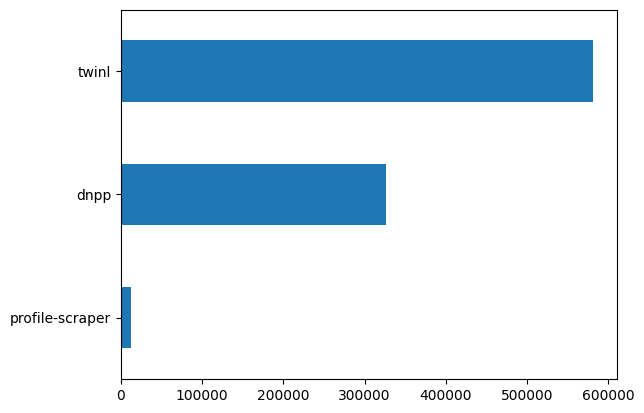

In [7]:
# Plot the number of tweets from different datasets.
final_df.source.value_counts().sort_values().plot(kind = 'barh')

In [8]:
# check&count duplicates between datasets
final_df['is_duplicated'] = final_df.duplicated(["tweet_id"])
final_df['is_duplicated'].sum()

264135

In [9]:
unique_df = final_df.drop_duplicates(subset=['tweet_id'])
unique_df = unique_df.drop_duplicates(subset=['text'])

In [10]:
print(f"lenght of the df after removing dublicates: {len(unique_df)}")

lenght of the df after removing dublicates: 610698


In [11]:
unique_df['twitter_username']  = unique_df['Author']

### Merge data with MP dataset from WikiData

In [12]:
mps = pd.read_csv('tweedekamerleden.csv')

In [13]:
# Some information about Party ended up in the 'Start Date' column. Fix this here: 
# Function to combine 'Start Date' and 'Party' columns
def combine_columns(row):
    if pd.isna(row['Party']):
        if pd.notna(row['Start Date']):
            return f"{row['Start Date']}"
        else:
            return row['Party']
    else:
        return row['Party']

# Apply the function to combine columns
mps['Political_Party'] = mps.apply(combine_columns, axis=1)

In [14]:
mps[['Start Date', 'Party', 'Political_Party']]
mps['Political_Party'].value_counts()

VVD                              223
PVV                               92
D66                               79
CDA                               66
PvdA                              63
SP                                51
GroenLinks-PvdA                   25
Nieuw Sociaal Contract            20
GroenLinks                        19
PvdD                              13
SGP                               13
CU                                13
ChristenUnie                      10
FVD                                9
DENK                               9
50PLUS                             9
PvdA[p]                            9
Partij voor de Dieren              8
BBB                                8
GL                                 8
GL[p]                              8
Volt                               5
Van Kooten-Arissen                 3
FVD[z]                             3
JA21                               3
Forum voor Democratie              3
JA21[ac]                           2
G

In [15]:
# Normalize party references. 
# Mapping dictionary for party names
party_mapping = {
    'GroenLinks': 'GroenLinks',
    'SP': 'SP',
    'CDA': 'CDA',
    'VVD': 'VVD',
    'D66': 'D66',
    'Forum voor Democratie': 'Forum voor Democratie',
    'PvdD': 'PvdD',
    'PVV': 'PVV',
    'BIJ1': 'BIJ1',
    'JA21[ac]': 'JA21',
    'GroenLinks-PvdA': 'GroenLinks-PvdA',
    'PvdA': 'PvdA',
    'CU': 'CU',
    'DENK': 'DENK',
    'Volt': 'Volt',
    'SGP': 'SGP',
    'Nieuw Sociaal Contract': 'Nieuw Sociaal Contract',
    'Partij voor de Dieren': 'Partij voor de Dieren',
    'ChristenUnie': 'ChristenUnie',
    'GL[p]': 'GroenLinks',
    'PvdA[p]': 'PvdA'
}

# Map party names
mps['normalized_party'] = mps['Political_Party'].map(party_mapping)
mps['normalized_party'].value_counts()

VVD                       223
PVV                        92
D66                        79
PvdA                       72
CDA                        66
SP                         51
GroenLinks                 27
GroenLinks-PvdA            25
Nieuw Sociaal Contract     20
SGP                        13
CU                         13
PvdD                       13
ChristenUnie               10
DENK                        9
Partij voor de Dieren       8
Volt                        5
Forum voor Democratie       3
JA21                        2
BIJ1                        1
Name: normalized_party, dtype: int64

In [ ]:
## Conduct the merge with the non-duplicated twitter data and the MP dataset from wikidata

In [16]:
df = pd.merge(unique_df, mps, on=['twitter_username'], how='left')

In [17]:
unique_df = df.drop_duplicates(subset=['tweet_id'])
df = unique_df.drop_duplicates(subset=['text'])

## remove RT's
df = df[~df['text'].str.startswith("RT @")]
len(df)

405838

In [ ]:
## Fix missing party members

In [18]:
# Mapping dictionary for party names
party_mapping = {
    'BramvanOjikGL': 'GroenLinks',
    'CorinneEllemeet': 'GroenLinks',
    'GroenLiesbeth': 'GroenLinks',
    'HenkKrol': '50PLUS',
    'JacquesMonasch': 'PvdA',
    'JoramvKlaveren': 'DENK',
    'jesseklaver': 'GroenLinks',
    'lindavoortman': 'GroenLinks',
    'rikgrashoff': 'GroenLinks',
    'tunahankuzu': 'DENK'
}

# Map party names only if normalized_party is NaN
df.loc[df['normalized_party'].isna(), 'normalized_party'] = df.loc[df['normalized_party'].isna(), 'Author'].map(party_mapping)

In [19]:
df['normalized_party'].value_counts()

GroenLinks                79652
VVD                       62256
SP                        57130
CDA                       49268
D66                       33709
PvdA                      32191
PVV                       19043
CU                        14047
BIJ1                      11949
PvdD                      11031
Forum voor Democratie      7778
GroenLinks-PvdA            6541
DENK                       3610
50PLUS                     3553
SGP                        3046
JA21                       3022
Nieuw Sociaal Contract     2633
Volt                       2350
ChristenUnie               1608
Partij voor de Dieren      1421
Name: normalized_party, dtype: int64

In [20]:
# Definieer de mapping
party_mapping = {
    'GroenLinks': 'GroenLinks',
    'VVD': 'VVD',
    'SP': 'SP',
    'CDA': 'CDA',
    'D66': 'D66',
    'PvdA': 'PvdA',
    'PVV': 'PVV',
    'CU': 'ChristenUnie',
    'BIJ1': 'BIJ1',
    'PvdD': 'Partij voor de Dieren',
    'Forum voor Democratie': 'Forum voor Democratie',
    'GroenLinks-PvdA': 'GroenLinks-PvdA',
    'DENK': 'DENK',
    '50PLUS': '50PLUS',
    'SGP': 'SGP',
    'JA21': 'JA21',
    'Nieuw Sociaal Contract': 'Nieuw Sociaal Contract',
    'Volt': 'Volt',
    'ChristenUnie': 'ChristenUnie',
    'Partij voor de Dieren': 'Partij voor de Dieren'
}


df['normalized_party'] = df['normalized_party'].map(party_mapping)
df['normalized_party'].value_counts()

GroenLinks                79652
VVD                       62256
SP                        57130
CDA                       49268
D66                       33709
PvdA                      32191
PVV                       19043
ChristenUnie              15655
Partij voor de Dieren     12452
BIJ1                      11949
Forum voor Democratie      7778
GroenLinks-PvdA            6541
DENK                       3610
50PLUS                     3553
SGP                        3046
JA21                       3022
Nieuw Sociaal Contract     2633
Volt                       2350
Name: normalized_party, dtype: int64

In [ ]:
### create Ideology mappings left -- right

In [21]:
# Dictionary to map parties to left/right scale values
party_ideology = {
    'GroenLinks': -3,   # Strongly left
    'SP': -2,            # Left
    'CDA': 0,            # Center
    'VVD': 3,            # Right
    'D66': 2,            # Center
    'Forum voor Democratie': 3,  # Right
    'FVD': 3,            # Right (Added)
    'PVV': 3,            # Right
    'BIJ1': -3,          # Strongly left
    'JA21': 3,           # Right
    'GroenLinks-PvdA': -2,  # Left
    'PvdA': -2,          # Center-left
    'DENK': -3,          # Strongly left
    'Volt': 1,           # Center
    'SGP': 3,            # Right
    'Nieuw Sociaal Contract': 1,  # Center
    'Partij voor de Dieren': -3,  # Left
    'ChristenUnie': 0, 
    '50PLUS': 1# Center-right
}

# Map parties to ideology
df['Ideology'] = df['normalized_party'].map(party_ideology)

In [22]:
# Dictionary to map ideology values to the three groups
ideology_group = {
    -3: 'Left',      # Strongly left
    -2: 'Left',      # Left
    -1: 'Center',    # Center-left
    0: 'Center',     # Center
    1: 'Center',     # Center
    2: 'Center',     # Center
    3: 'Right'       # Right
}

# Map ideology values to ideology groups
df['Ideology_Group'] = df['Ideology'].map(ideology_group)

In [23]:
df[['Ideology_Group', 'Ideology', 'normalized_party', 'Author']]
#df['text']

,Ideology_Group,Ideology,normalized_party,Author
0,Center,0,CDA,sybrandbuma
2,Center,0,CDA,sybrandbuma
6,Center,0,CDA,sybrandbuma
8,Center,0,CDA,sybrandbuma
12,Center,0,CDA,sybrandbuma
...,...,...,...,...
1323731,Right,3,VVD,marielle_paul
1323733,Right,3,VVD,marielle_paul
1323735,Right,3,VVD,marielle_paul
1323739,Right,3,VVD,marielle_paul


In [24]:
df[['Ideology_Group', 'Ideology', 'normalized_party']].drop_duplicates()

,Ideology_Group,Ideology,normalized_party
0,Center,0,CDA
520,Center,2,D66
7648,Right,3,VVD
10442,Left,-3,GroenLinks
48563,Left,-2,PvdA
63638,Right,3,PVV
95444,Left,-3,BIJ1
123685,Right,3,JA21
134904,Left,-3,Partij voor de Dieren
142209,Left,-2,SP


In [ ]:
## Create dataset specific for migration

In [25]:
# Define keywords and synonyms with wildcard matching
keywords = [
    'immigratie',
    'migratie',
    'migrant',
    'vluchteling',
    'asiel*',
    'vreemdeling',
    'deportatie',
    'integratie',
    'naturalisatie',
    'verblijfsvergunning',
    'grensbeveiliging',
    'migratiebeleid',
    'emigratie',
    'remigratie',
    'illegalen',
    'grenscontrole',
    'grensbewaking',
    'vluchtelingenkamp',
    'migrantenstroom',
    'migratieroute',
    'migratiecrisis',
    'migratieachtergrond',
    'gastarbeider',
    'migratienetwerk',
    'migratiekwestie',
    'migratieproblematiek',
    # Additional synonyms and related terms with wildcards
    'vluchtelingen*',
    'asielzoek*',
    'illegalit*',
    'grenspolitiek*',
    'migratiestromen*',
    'grensbeleid*',
    'grensoverschrijding*',
    'migratiedruk*',
    'immigratiebeleid*',
    'migratiepolitiek*',
    'migratiecrisis*',
    'migratieachtergrond*',
    'vluchtelingencrisis*',
    'emigranten*',
    'immigratiekwestie*',
    'immigratieproblematiek*',
]

# Create regex pattern to match any of the keywords with word boundaries
pattern = '|'.join([r'\b{}\b'.format(keyword) for keyword in keywords])

# Filter 'text' column based on the regex pattern
filtered_df = df[df['text'].str.contains(pattern, case=False, regex=True)]
len(filtered_df)

2561

In [26]:
filtered_df.to_csv('immigratie_tweets_non_stratefied.csv')

In [ ]:
filtered_df = pd.read_csv('immigratie_tweets_non_stratefied.csv')

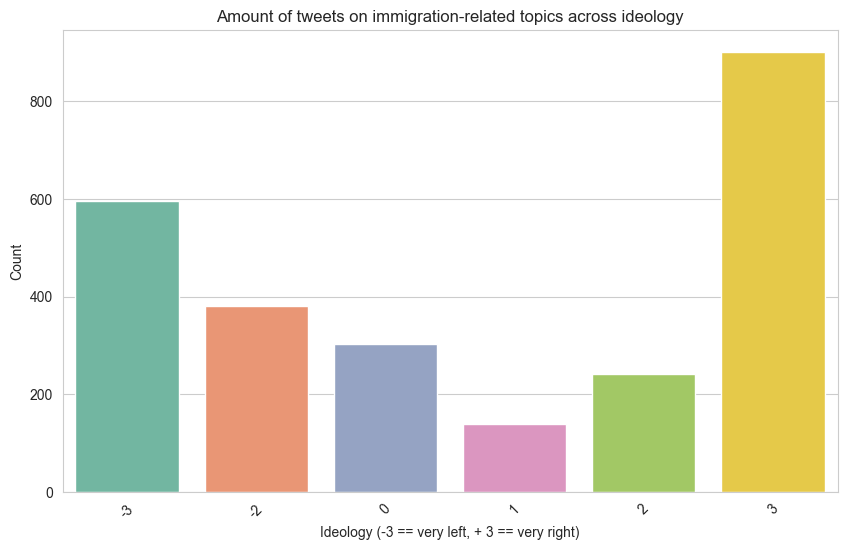

In [27]:
# Set the style
sns.set_style("whitegrid")

# Plot the count of each ideology
plt.figure(figsize=(10, 6))
sns.countplot(data=filtered_df, x='Ideology', palette='Set2')
plt.title('Amount of tweets on immigration-related topics across ideology')
plt.xlabel('Ideology (-3 == very left, + 3 == very right)')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

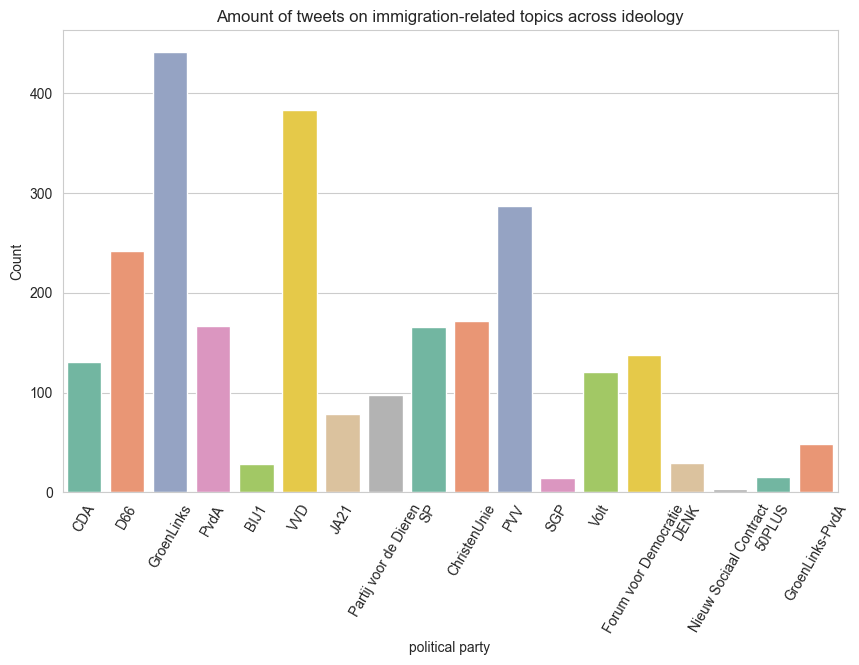

In [28]:
# Set the style
sns.set_style("whitegrid")

# Plot the count of each ideology
plt.figure(figsize=(10, 6))
sns.countplot(data=filtered_df, x='normalized_party', palette='Set2')
plt.title('Amount of tweets on immigration-related topics across ideology')
plt.xlabel('political party')
plt.ylabel('Count')
plt.xticks(rotation=60)  # Rotate x-axis labels for better visibility
plt.show()


In [ ]:
## Create stratefied sample. 

# Step 1: stratefied sample of the immigration-specific tweets

In [29]:
import pandas as pd

# Assuming filtered_df is your DataFrame
# Print distribution before stratified sampling
print('Distribution before stratified sampling:')
print(filtered_df['Ideology_Group'].value_counts())

# Define the desired number of samples per group
samples_per_group = 620
total_samples = samples_per_group * filtered_df['Ideology_Group'].nunique()

# Calculate how many groups are in the DataFrame
num_groups = filtered_df['Ideology_Group'].nunique()

# Ensure we are not trying to sample more than available in any group
min_group_size = filtered_df.groupby('Ideology_Group').size().min()
if samples_per_group > min_group_size:
    raise ValueError(f"Requested samples per group ({samples_per_group}) exceed the minimum group size ({min_group_size}).")

# Define a function to sample each group
def stratified_sample(group, n):
    return group.sample(n=n)

# Apply the stratified sampling function to each group
stratified_samples = filtered_df.groupby('Ideology_Group', group_keys=False).apply(lambda x: stratified_sample(x, samples_per_group))

# Reset the index of the sampled DataFrame
stratified_samples.reset_index(drop=True, inplace=True)

# Print distribution after stratified sampling
print('Distribution after stratified sampling:')
print(stratified_samples['Ideology_Group'].value_counts())


Distribution before stratified sampling:
Left      977
Right     900
Center    684
Name: Ideology_Group, dtype: int64
Distribution after stratified sampling:
Center    620
Left      620
Right     620
Name: Ideology_Group, dtype: int64


In [30]:
stratified_samples['immigration'] = 'yes'
stratified_samples.to_csv('final_stratified_immigration.csv')

In [31]:
print(len(stratified_samples))

1860


In [32]:
print(set(df['normalized_party']))

{'PVV', 'GroenLinks', 'BIJ1', 'Nieuw Sociaal Contract', 'VVD', 'DENK', 'D66', 'Volt', 'ChristenUnie', '50PLUS', 'GroenLinks-PvdA', 'Forum voor Democratie', 'SGP', 'JA21', 'CDA', 'Partij voor de Dieren', 'PvdA', 'SP'}


In [33]:
for i in stratified_samples['text'][:100]:
    print(i)
    print()

🎙Een nieuwe Podtcast ➡️In deze aflevering spreek ik met @TamerAlalloush @openembassynl over de ontvangst van vluchtelingen in Nederland. Over verschillen in ontvangt en wat je zelf kunt doen. 

🎧Luisteren? https://t.co/yijtkadET9

(Of zoek "Podtcast" in je podcastapp)

VVD stelt: we zijn teveel geld kwijt aan mensen die geen recht hebben op asiel en daarom moet men buiten de EU die aanvragen doen. Oftewel, we verschuiven het probleem naar ver weg, dan hoef ik er geen verantwoordelijkheid voor te nemen.

De tekorten in de opvang blijven oplopen. Dit weten we al maanden, maar de beloofde spreidingswet laat op zich wachten. Kabinet moet nu in actie komen. #asiel #migratie #opvang

Opvang asielzoekers: tekort aan bijna 40.000 plekken /via @Nieuwsuur https://t.co/MAbBsVWlrp

Andere belangrijke onderwerpen waren energie- en voedselprijzen, multilaterale samenwerking, klimaatverandering, #SIDS, bestrijding van criminaliteit, migratie, en de relatie met Venezuela. 2/3

Vorige week nog boden de

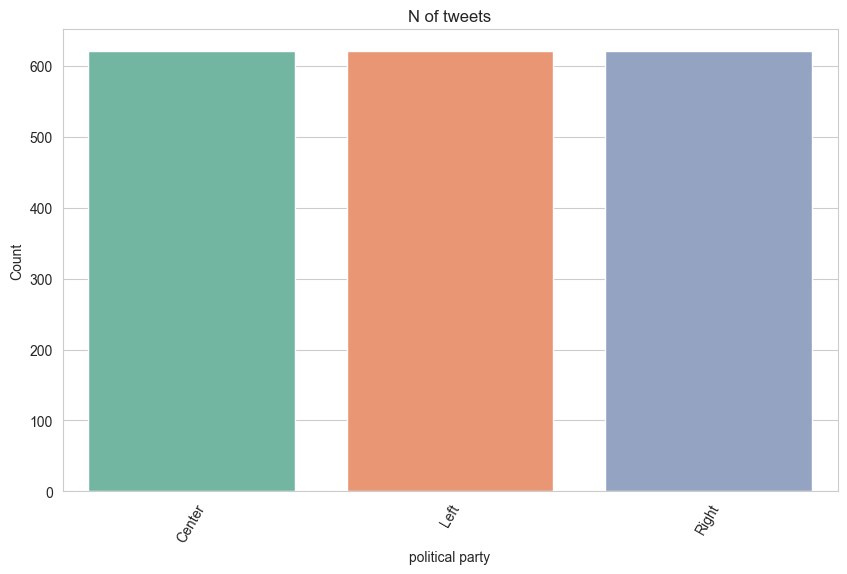

In [34]:
# Set the style
sns.set_style("whitegrid")

# Plot the count of each ideology
plt.figure(figsize=(10, 6))
sns.countplot(data=stratified_samples, x='Ideology_Group', palette='Set2')
plt.title('N of tweets')
plt.xlabel('political party')
plt.ylabel('Count')
plt.xticks(rotation=60)  # Rotate x-axis labels for better visibility
plt.show()
